In [3]:
import pandas as pd


pfad = './DATA/Reservation_Data/station_reservations.csv'

#open the csv and make df out of it
df_Reservations = pd.read_csv(pfad)

print(df_Reservations.head())

             timestamp                      station_name  \
0  2025-07-19T01:37:24  M Herzbergstraße/Industriegebiet   
1  2025-07-19T01:37:24  M Herzbergstraße/Industriegebiet   
2  2025-07-19T01:37:29  M Herzbergstraße/Industriegebiet   
3  2025-07-19T01:37:29  M Herzbergstraße/Industriegebiet   
4  2025-07-19T01:37:34  M Herzbergstraße/Industriegebiet   

              event_type  duration_seconds  booked_bikes_entry  \
0  not_booked:bike_taken                 0                   0   
1  not_booked:bike_taken                 0                   0   
2  not_booked:bike_taken                 0                   0   
3  not_booked:bike_taken                 0                   0   
4  not_booked:bike_taken                 0                   0   

   booked_bikes_exit  available_bikes_before  available_bikes_after  \
0                  0                       2                      1   
1                  0                       2                      1   
2                  0         

In [12]:
import pandas as pd

# Spaltennamen säubern
df_Reservations.columns = df_Reservations.columns.str.strip()

# Sortieren
df_Reservations = df_Reservations.sort_values(['station_name', 'timestamp']).reset_index(drop=True)

# Länge vor dem Cleaning
len_start = len(df_Reservations)

# Zeitfenster-Spalte für 30-Minuten-Buckets
df_Reservations['time_block'] = pd.to_datetime(df_Reservations['timestamp']).dt.floor('30T')

# Nur das Event "not_booked:bike_taken" betrachten
mask_type = df_Reservations['event_type'] == 'not_booked:bike_taken'

# Schlüsselfelder für Identität
key_cols = [
    'station_name', 'event_type', 'duration_seconds',
    'booked_bikes_entry', 'booked_bikes_exit',
    'available_bikes_before', 'available_bikes_after',
    'bikes_available_to_rent', 'bike_racks', 'free_racks', 'special_racks'
]

# Maske für aufeinanderfolgende identische Events innerhalb 30 Minuten für die Station
mask = (
    mask_type &
    df_Reservations[key_cols].eq(df_Reservations[key_cols].shift()).all(axis=1) &
    df_Reservations['station_name'].eq(df_Reservations['station_name'].shift()) &
    df_Reservations['time_block'].eq(df_Reservations['time_block'].shift())
)

# Logging: Welche Zeilen werden entfernt?
removed = df_Reservations[mask]

# Cleanes DataFrame
df_clean = df_Reservations[~mask].reset_index(drop=True)

# Länge nach dem Cleaning
len_clean = len(df_clean)

# 1. Gesamtzahl entfernt
print(f"Total duplicate 'not_booked:bike_taken' rows removed (30min-bucket): {len(removed)}")

# 2. Anzahl pro Station
removed_counts = removed['station_name'].value_counts()
print("\nRemoved duplicates per station:")
print(removed_counts)

# 3. Stationen mit z.B. mindestens 20 entfernten Dubletten
threshold = 20
stations_many = removed_counts[removed_counts >= threshold]
if not stations_many.empty:
    print(f"\nStations with more than {threshold} duplicates removed:")
    for station, count in stations_many.items():
        print(f"- {station}: {count} times")
else:
    print(f"\nNo station had more than {threshold} duplicates removed.")

# 4. DataFrame-Längen vor und nach dem Cleaning
print(f"\nLength before cleaning: {len_start}")
print(f"Length after cleaning: {len_clean}")

# Spalte wieder entfernen, wenn nicht mehr gebraucht
df_clean = df_clean.drop(columns=['time_block'])

#print nur die header vom df bitte

#zähle und printe die event_types wie oft not_booked:bike taken, booked:bike taken, booked:not taken 

event_counts = df_clean['event_type'].value_counts()
print("\nEvent type counts:")
print(event_counts)
print(df_clean.columns.tolist())



Total duplicate 'not_booked:bike_taken' rows removed (30min-bucket): 217653

Removed duplicates per station:
station_name
Tschaikowskistraße (Grabbeallee)                      176254
EDEKA Gäth (Steglitzer Damm)                           15844
M Herzbergstraße/Industriegebiet                       13871
Hermannstraße/Glasower Straße                           5249
**Jelbi S+U Hauptbahnhof/Europaplatz West (MOA/EW)       114
                                                       ...  
Michaelkirchbrücke                                         1
Mildred-Harnack-Straße                                     1
Minna-Flake-Platz                                          1
Munsterdamm (Sommerbad am Insulaner)                       1
M Roederplatz (Weißenseer Weg)                             1
Name: count, Length: 1271, dtype: int64

Stations with more than 20 duplicates removed:
- Tschaikowskistraße (Grabbeallee): 176254 times
- EDEKA Gäth (Steglitzer Damm): 15844 times
- M Herzbergstraße/Industr

/var/folders/h5/zhw0n5ns1xggx80nhjzz4bs40000gn/T/ipykernel_80825/3770537981.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_Reservations['time_block'] = pd.to_datetime(df_Reservations['timestamp']).dt.floor('30T')


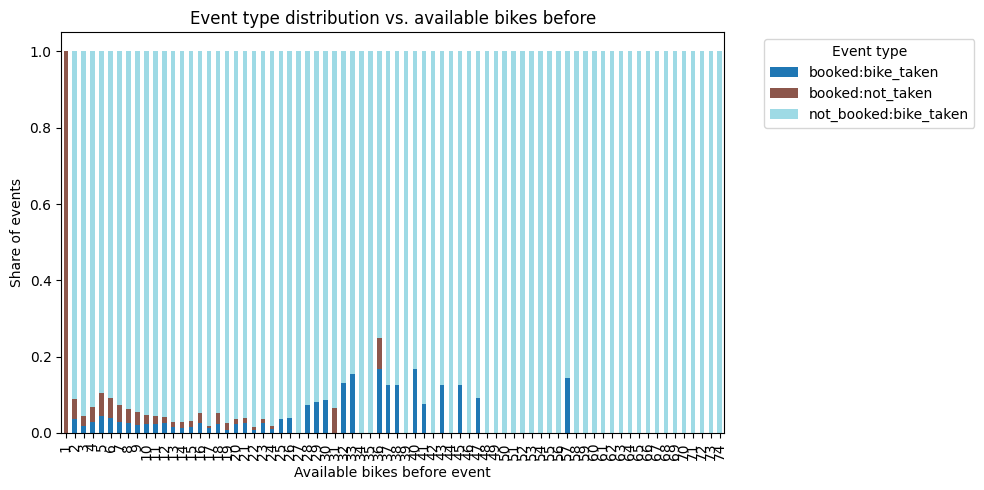

In [13]:
import matplotlib.pyplot as plt

# Zähle Events je available_bikes_before und event_type
counts = df_Reservations.groupby(['available_bikes_before', 'event_type']).size().unstack(fill_value=0)

# Nach Anteil pro Zeile (optional)
proportions = counts.div(counts.sum(axis=1), axis=0)

proportions.plot(kind='bar', stacked=True, figsize=(10,5), colormap='tab20')
plt.xlabel('Available bikes before event')
plt.ylabel('Share of events')
plt.title('Event type distribution vs. available bikes before')
plt.legend(title='Event type', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


/var/folders/h5/zhw0n5ns1xggx80nhjzz4bs40000gn/T/ipykernel_80825/2318132443.py:4: RuntimeWarning: invalid value encountered in scalar divide
  success_rate = grouped.apply(lambda x: (x['event_type'] == 'booked:bike_taken').sum() /
/var/folders/h5/zhw0n5ns1xggx80nhjzz4bs40000gn/T/ipykernel_80825/2318132443.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  success_rate = grouped.apply(lambda x: (x['event_type'] == 'booked:bike_taken').sum() /


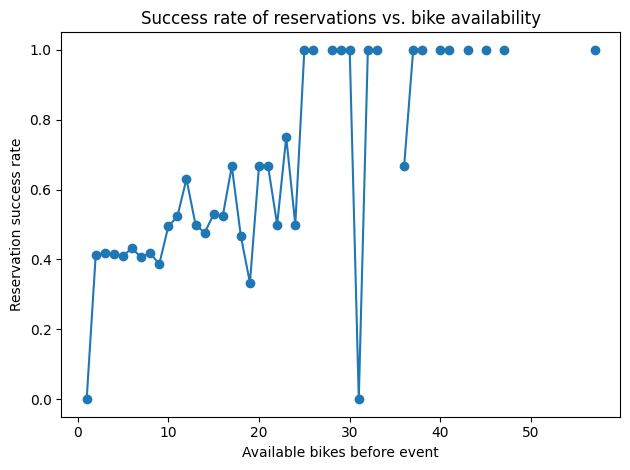

In [14]:
success = df_Reservations['event_type'] == 'booked:bike_taken'
fail = df_Reservations['event_type'] == 'booked:not_taken'
grouped = df_Reservations.groupby('available_bikes_before')
success_rate = grouped.apply(lambda x: (x['event_type'] == 'booked:bike_taken').sum() / 
                                      ((x['event_type'] == 'booked:bike_taken').sum() + (x['event_type'] == 'booked:not_taken').sum())
                            )

success_rate.plot(marker='o')
plt.xlabel('Available bikes before event')
plt.ylabel('Reservation success rate')
plt.title('Success rate of reservations vs. bike availability')
plt.tight_layout()
plt.show()


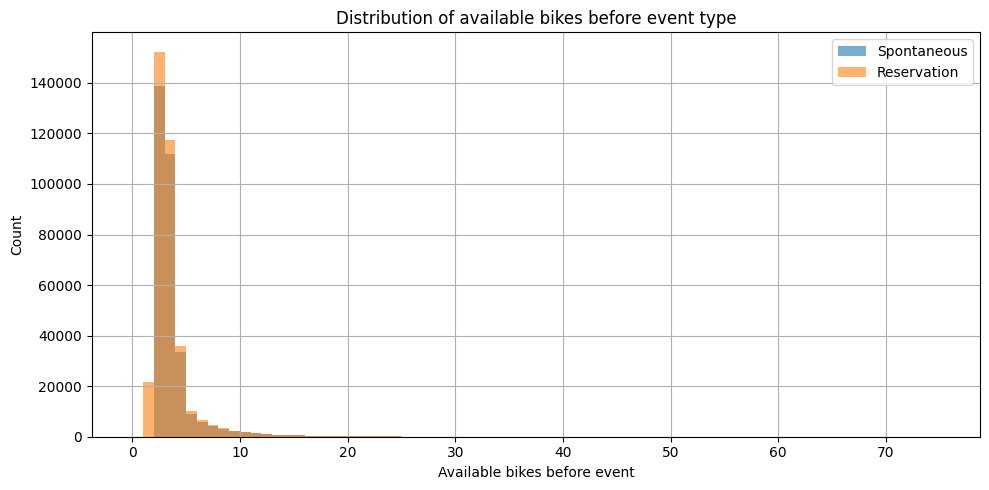

In [15]:
plt.figure(figsize=(10,5))
df_Reservations[df_Reservations['event_type'] == 'not_booked:bike_taken']['available_bikes_before'].hist(
    bins=range(0, df_Reservations['available_bikes_before'].max()+2), alpha=0.6, label='Spontaneous')
df_Reservations[df_Reservations['event_type'].str.contains('booked')]['available_bikes_before'].hist(
    bins=range(0, df_Reservations['available_bikes_before'].max()+2), alpha=0.6, label='Reservation')
plt.xlabel('Available bikes before event')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of available bikes before event type')
plt.tight_layout()
plt.show()


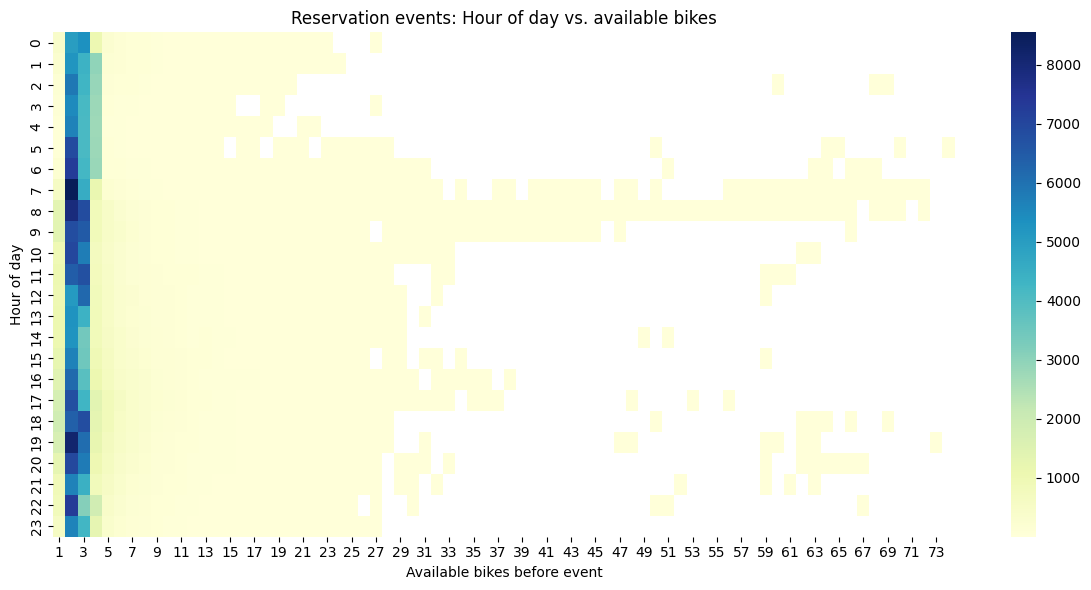

In [16]:
df_Reservations['hour'] = pd.to_datetime(df_Reservations['timestamp']).dt.hour
pivot = df_Reservations[df_Reservations['event_type'].str.contains('booked')].pivot_table(
    index='hour', columns='available_bikes_before', values='event_type', aggfunc='count'
)
import seaborn as sns
plt.figure(figsize=(12,6))
sns.heatmap(pivot, annot=False, cmap='YlGnBu')
plt.xlabel('Available bikes before event')
plt.ylabel('Hour of day')
plt.title('Reservation events: Hour of day vs. available bikes')
plt.tight_layout()
plt.show()


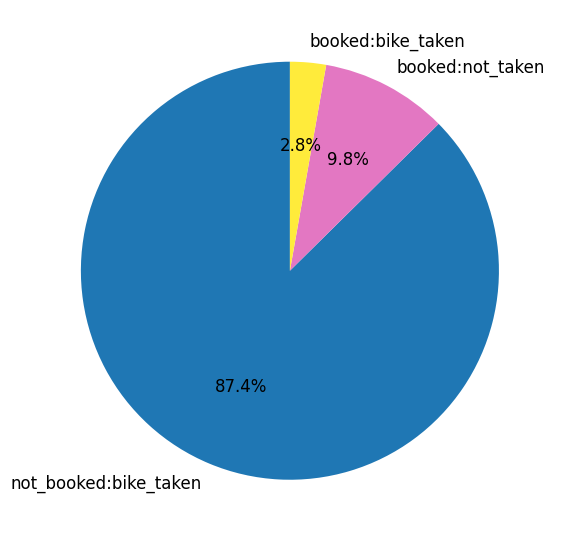

In [75]:
import matplotlib.pyplot as plt

# Farben definieren: Blau, Magenta, Gelb
colors = ['#1f77b4', '#e377c2', '#ffeb3b']

event_counts = df_Reservations['event_type'].value_counts()

plt.figure(figsize=(6,6))
wedges, texts, autotexts = plt.pie(
    event_counts,
    labels=event_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12}
)

# Optional: Kreis leicht auflockern
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()


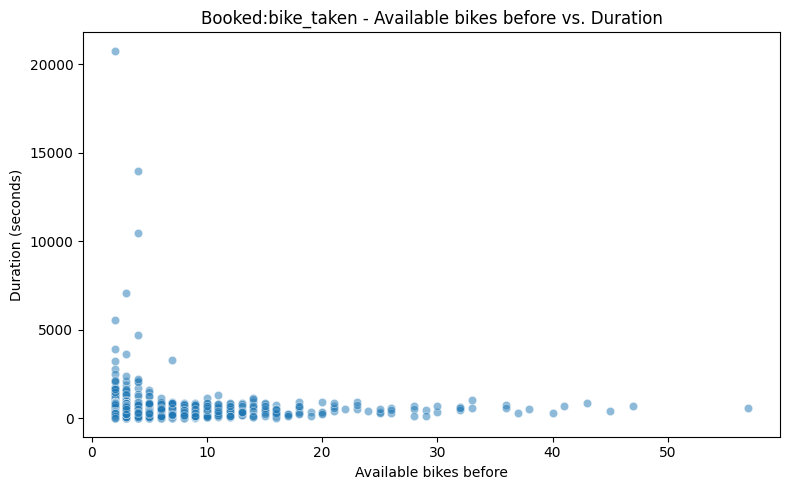

Correlation between 'available_bikes_before' and 'duration_seconds' (booked:bike_taken): 0.06


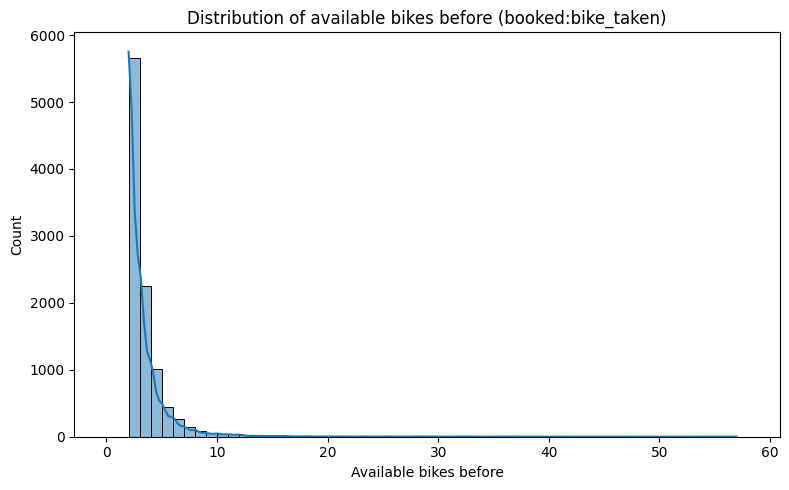

In [18]:
import seaborn as sns
import numpy as np

booked_taken = df_Reservations[df_Reservations['event_type'] == 'booked:bike_taken']

plt.figure(figsize=(8,5))
sns.scatterplot(
    x='available_bikes_before',
    y='duration_seconds',  # oder ein anderes Feld, falls sinnvoller
    data=booked_taken,
    alpha=0.5
)
plt.xlabel('Available bikes before')
plt.ylabel('Duration (seconds)')  # Passe an, falls du was anderes plotten willst
plt.title('Booked:bike_taken - Available bikes before vs. Duration')
plt.tight_layout()
plt.show()

# Korrelation berechnen (falls du duration_seconds vs. available_bikes_before willst)
corr = booked_taken['available_bikes_before'].corr(booked_taken['duration_seconds'])
print(f"Correlation between 'available_bikes_before' and 'duration_seconds' (booked:bike_taken): {corr:.2f}")

# Wenn du nur die Verteilung der available_bikes_before bei booked:bike_taken zeigen willst:
plt.figure(figsize=(8,5))
sns.histplot(booked_taken['available_bikes_before'], bins=range(0, booked_taken['available_bikes_before'].max()+2), kde=True)
plt.xlabel('Available bikes before')
plt.ylabel('Count')
plt.title('Distribution of available bikes before (booked:bike_taken)')
plt.tight_layout()
plt.show()


/var/folders/h5/zhw0n5ns1xggx80nhjzz4bs40000gn/T/ipykernel_80825/1335599810.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  booked_taken['hour'] = pd.to_datetime(booked_taken['timestamp']).dt.hour


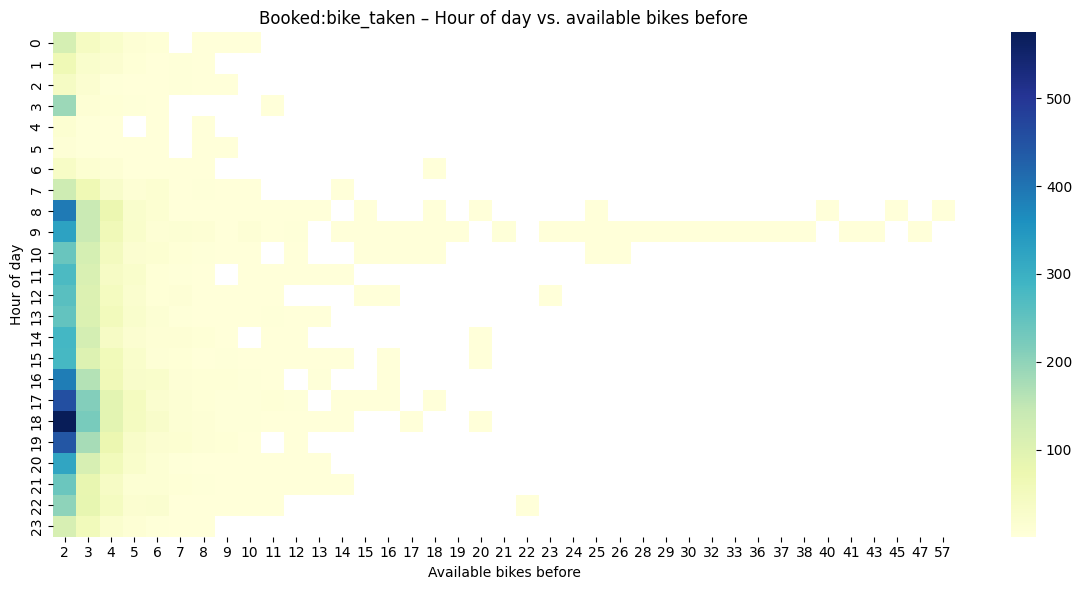

In [19]:
booked_taken['hour'] = pd.to_datetime(booked_taken['timestamp']).dt.hour

pivot = booked_taken.pivot_table(
    index='hour',
    columns='available_bikes_before',
    values='event_type',
    aggfunc='count'
)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, annot=False, cmap='YlGnBu')
plt.xlabel('Available bikes before')
plt.ylabel('Hour of day')
plt.title('Booked:bike_taken – Hour of day vs. available bikes before')
plt.tight_layout()
plt.show()


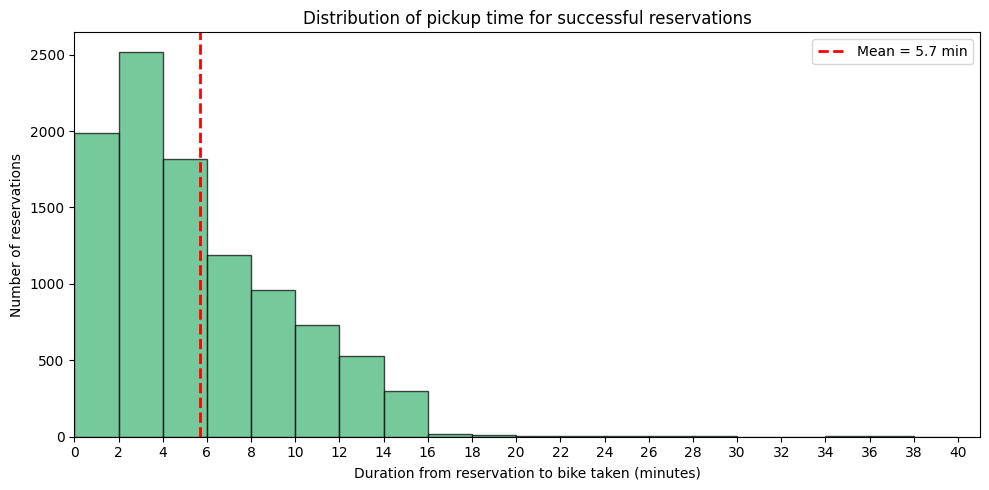

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Filter für erfolgreiche Reservierungen
taken = df_Reservations[df_Reservations['event_type'] == 'booked:bike_taken']

# Werte in Minuten umwandeln
durations_min = taken['duration_seconds'] / 60


# X-Achse in 2-Minuten-Schritten (z.B. bis 60 Minuten)
max_minutes = int(min(40, durations_min.max()))
bins = np.arange(0, max_minutes + 2, 2)  # 2er Schritte

plt.figure(figsize=(10,5))
plt.hist(durations_min, bins=bins, color='mediumseagreen', alpha=0.7, edgecolor='black')
plt.axvline(durations_min.mean(), color='red', linestyle='dashed', linewidth=2,
            label=f"Mean = {durations_min.mean():.1f} min")
plt.xlabel('Duration from reservation to bike taken (minutes)')
plt.ylabel('Number of reservations')
plt.title('Distribution of pickup time for successful reservations')
plt.xticks(np.arange(0, max_minutes+2, 2))  # Nur 2er Schritte als Tick
plt.xlim(0, max_minutes + 1)
plt.legend()
plt.tight_layout()
plt.show()


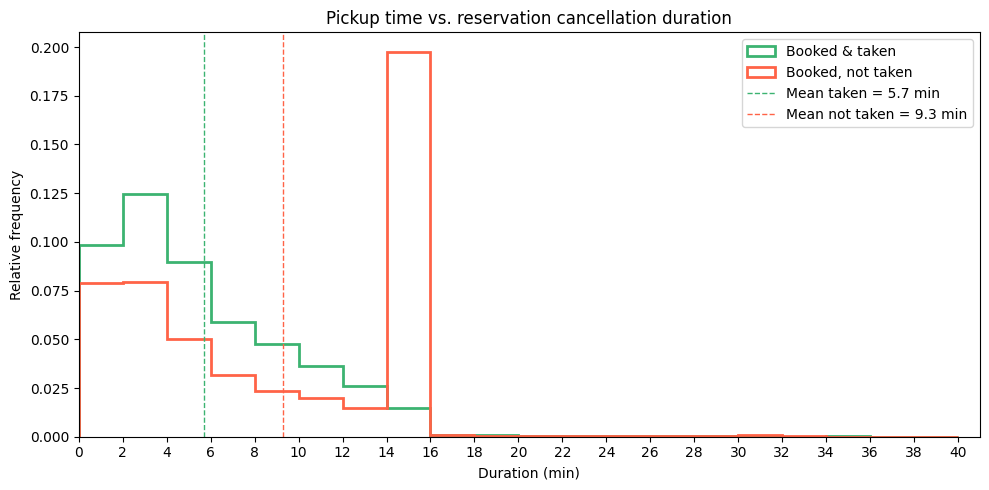

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Filter für erfolgreiche und nicht genutzte Reservierungen
taken = df_Reservations[df_Reservations['event_type'] == 'booked:bike_taken']
not_taken = df_Reservations[df_Reservations['event_type'] == 'booked:not_taken']

# Werte in Minuten umwandeln
durations_taken = taken['duration_seconds'] / 60
durations_not_taken = not_taken['duration_seconds'] / 60

# Gemeinsame X-Achse (maximal 40 Minuten oder das Maximum in den Daten)
max_minutes = int(
    max(
        min(40, durations_taken.max() if not durations_taken.empty else 0),
        min(40, durations_not_taken.max() if not durations_not_taken.empty else 0)
    )
)
bins = np.arange(0, max_minutes + 2, 2)  # 2-Minuten-Schritte

plt.figure(figsize=(10,5))

# Histogramm-Linienplot (density=True für Vergleichbarkeit)
plt.hist(
    durations_taken, bins=bins, density=True,
    histtype='step', linewidth=2, color='mediumseagreen', label='Booked & taken'
)
plt.hist(
    durations_not_taken, bins=bins, density=True,
    histtype='step', linewidth=2, color='tomato', label='Booked, not taken'
)

if not durations_taken.empty:
    plt.axvline(durations_taken.mean(), color='mediumseagreen', linestyle='dashed', linewidth=1,
                label=f"Mean taken = {durations_taken.mean():.1f} min")
if not durations_not_taken.empty:
    plt.axvline(durations_not_taken.mean(), color='tomato', linestyle='dashed', linewidth=1,
                label=f"Mean not taken = {durations_not_taken.mean():.1f} min")

plt.xlabel('Duration (min)')
plt.ylabel('Relative frequency')
plt.title('Pickup time vs. reservation cancellation duration')
plt.xticks(np.arange(0, max_minutes+2, 2))
plt.xlim(0, max_minutes + 1)
plt.legend()
plt.tight_layout()
plt.show()


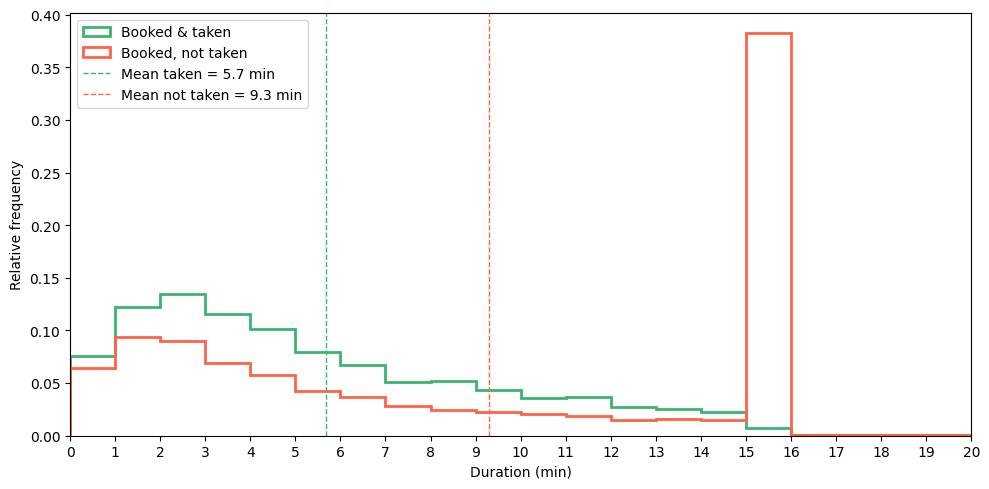

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Filter für erfolgreiche und nicht genutzte Reservierungen
taken = df_Reservations[df_Reservations['event_type'] == 'booked:bike_taken']
not_taken = df_Reservations[df_Reservations['event_type'] == 'booked:not_taken']

# Werte in Minuten umwandeln
durations_taken = taken['duration_seconds'] / 60
durations_not_taken = not_taken['duration_seconds'] / 60

# Gemeinsame X-Achse: maximal 20 Minuten
max_minutes = 20
bins = np.arange(0, max_minutes + 1, 1)  # 1-Minuten-Schritte

plt.figure(figsize=(10,5))

# Histogramm-Linienplot (density=True für Vergleichbarkeit)
plt.hist(
    durations_taken, bins=bins, density=True,
    histtype='step', linewidth=2, color='mediumseagreen', label='Booked & taken'
)
plt.hist(
    durations_not_taken, bins=bins, density=True,
    histtype='step', linewidth=2, color='tomato', label='Booked, not taken'
)

if not durations_taken.empty:
    plt.axvline(durations_taken.mean(), color='mediumseagreen', linestyle='dashed', linewidth=1,
                label=f"Mean taken = {durations_taken.mean():.1f} min")
if not durations_not_taken.empty:
    plt.axvline(durations_not_taken.mean(), color='tomato', linestyle='dashed', linewidth=1,
                label=f"Mean not taken = {durations_not_taken.mean():.1f} min")

plt.xlabel('Duration (min)')
plt.ylabel('Relative frequency')
# plt.title('Pickup time vs. reservation cancellation duration')
plt.xticks(np.arange(0, max_minutes+1, 1))
plt.xlim(0, max_minutes)
plt.legend()
plt.tight_layout()
plt.show()


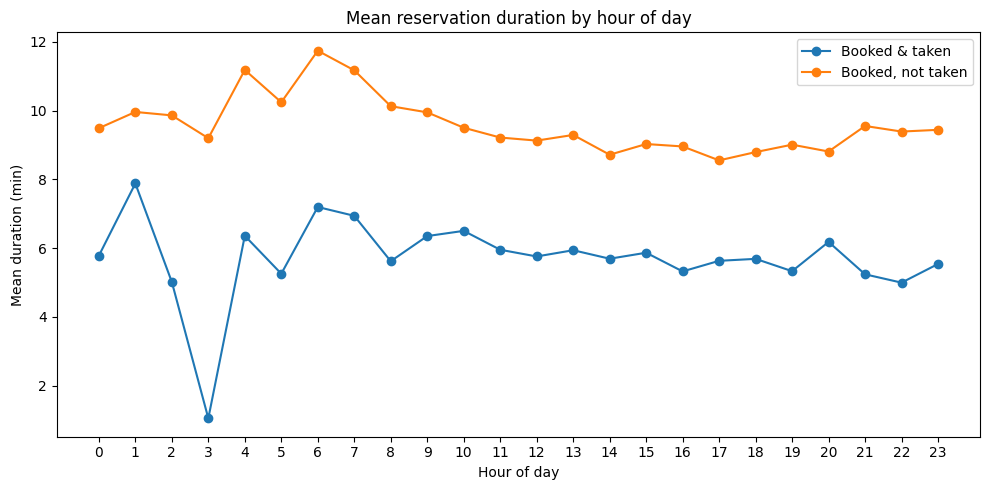

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Stunde extrahieren
df_Reservations['hour'] = pd.to_datetime(df_Reservations['timestamp']).dt.hour

# Mittelwerte pro Stunde
taken = df_Reservations[df_Reservations['event_type'] == 'booked:bike_taken']
not_taken = df_Reservations[df_Reservations['event_type'] == 'booked:not_taken']

mean_taken_by_hour = taken.groupby('hour')['duration_seconds'].mean() / 60
mean_not_taken_by_hour = not_taken.groupby('hour')['duration_seconds'].mean() / 60

plt.figure(figsize=(10,5))
plt.plot(mean_taken_by_hour.index, mean_taken_by_hour.values, marker='o', label='Booked & taken')
plt.plot(mean_not_taken_by_hour.index, mean_not_taken_by_hour.values, marker='o', label='Booked, not taken')
plt.xlabel('Hour of day')
plt.ylabel('Mean duration (min)')
plt.title('Mean reservation duration by hour of day')
plt.xticks(range(0,24))
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
# Höchster Wert für available_bikes_before
max_bikes = df_Reservations['available_bikes_before'].max()
print(f"Maximum available_bikes_before: {max_bikes}")

# Zeige alle Zeilen mit diesem Maximalwert (inkl. Station etc.)
most_bikes_df = df_Reservations[df_Reservations['available_bikes_before'] == max_bikes]
print("\nRows with maximum available_bikes_before:")
print(most_bikes_df[['timestamp', 'station_name', 'available_bikes_before']])


Maximum available_bikes_before: 74

Rows with maximum available_bikes_before:
                 timestamp                         station_name  \
76344  2025-07-31T05:16:19  Jelbi S Buch/P+R-Parkplatz (BUC/BP)   

       available_bikes_before  
76344                      74  


In [33]:
# Die 20 größten Werte von available_bikes_before finden
top_bikes_values = df_Reservations['available_bikes_before'].drop_duplicates().sort_values(ascending=False).head(20)

print("Top 20 unique values for available_bikes_before:")
print(top_bikes_values.to_list())

# Alle Zeilen mit diesen Top-Werten, sortiert nach Wert und Zeit
top_bikes_df = df_Reservations[df_Reservations['available_bikes_before'].isin(top_bikes_values)]
top_bikes_df = top_bikes_df.sort_values(['available_bikes_before', 'timestamp'], ascending=[False, True])

# Die ersten 20 Zeilen ausgeben
print("\nTop 20 rows with the highest available_bikes_before values:")
print(top_bikes_df.head(20).to_string(index=False))


Top 20 unique values for available_bikes_before:
[74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55]

Top 20 rows with the highest available_bikes_before values:
          timestamp                        station_name            event_type  duration_seconds  booked_bikes_entry  booked_bikes_exit  available_bikes_before  available_bikes_after  bikes_available_to_rent  bike_racks  free_racks  special_racks          time_block  hour
2025-07-31T05:16:19 Jelbi S Buch/P+R-Parkplatz (BUC/BP) not_booked:bike_taken                 0                   0                  0                      74                     73                       73          40           0              0 2025-07-31 05:00:00     5
2025-07-30T19:59:11 Jelbi S Buch/P+R-Parkplatz (BUC/BP) not_booked:bike_taken                 0                   0                  0                      73                     72                       72          40           0              0 2025-07-30 19:30:00

In [34]:
# Filter nur auf 'booked:bike_taken'
filtered = df_Reservations[df_Reservations['event_type'] == 'booked:bike_taken']

# Die 20 größten Werte von available_bikes_before finden
top_bikes_values = filtered['available_bikes_before'].drop_duplicates().sort_values(ascending=False).head(20)
print("Top 20 unique values for available_bikes_before (booked:bike_taken):")
print(top_bikes_values.to_list())

# Alle Zeilen mit diesen Top-Werten, sortiert nach Wert und Zeit
top_bikes_df = filtered[filtered['available_bikes_before'].isin(top_bikes_values)]
top_bikes_df = top_bikes_df.sort_values(['available_bikes_before', 'timestamp'], ascending=[False, True])

# Die ersten 20 Zeilen ausgeben (alle Spalten)
print("\nTop 20 rows with the highest available_bikes_before values (booked:bike_taken):")
print(top_bikes_df.head(20).to_string(index=False))


Top 20 unique values for available_bikes_before (booked:bike_taken):
[57, 47, 45, 43, 41, 40, 38, 37, 36, 33, 32, 30, 29, 28, 26, 25, 24, 23, 22, 21]

Top 20 rows with the highest available_bikes_before values (booked:bike_taken):
          timestamp                        station_name        event_type  duration_seconds  booked_bikes_entry  booked_bikes_exit  available_bikes_before  available_bikes_after  bikes_available_to_rent  bike_racks  free_racks  special_racks          time_block  hour
2025-07-25T08:46:25 Jelbi S Buch/P+R-Parkplatz (BUC/BP) booked:bike_taken               563                   1                  0                      57                     56                       56          40           0              0 2025-07-25 08:30:00     8
2025-07-31T09:06:26 Jelbi S Buch/P+R-Parkplatz (BUC/BP) booked:bike_taken               702                   1                  2                      47                     46                       44          40           0       

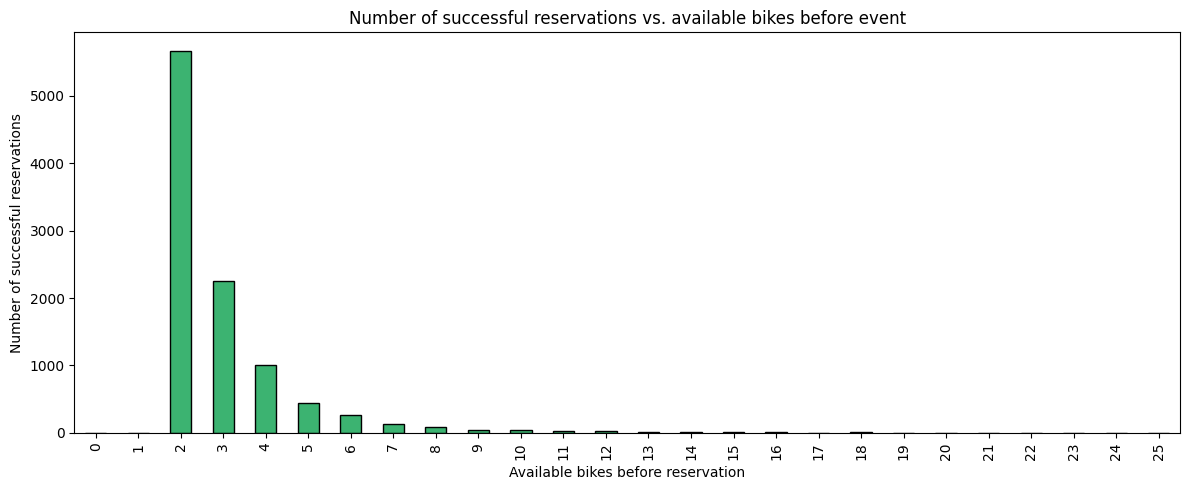

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Filter: nur erfolgreiche Reservierungen
booked_taken = df_Reservations[df_Reservations['event_type'] == 'booked:bike_taken']

# Zähle Buchungen pro Anzahl verfügbarer Bikes (0 bis 25)
counts = booked_taken['available_bikes_before'].value_counts().reindex(range(0, 26), fill_value=0)

plt.figure(figsize=(12,5))
counts.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.xlabel('Available bikes before reservation')
plt.ylabel('Number of successful reservations')
plt.title('Number of successful reservations vs. available bikes before event')
plt.xticks(np.arange(0, 26, 1))  # 1er Schritte auf der X-Achse
plt.tight_layout()
plt.show()


In [37]:

booked_taken = df_Reservations[df_Reservations['event_type'] == 'booked:bike_taken']

print(booked_taken[booked_taken['available_bikes_before'] == 1])


Empty DataFrame
Columns: [timestamp, station_name, event_type, duration_seconds, booked_bikes_entry, booked_bikes_exit, available_bikes_before, available_bikes_after, bikes_available_to_rent, bike_racks, free_racks, special_racks, time_block, hour]
Index: []


/var/folders/h5/zhw0n5ns1xggx80nhjzz4bs40000gn/T/ipykernel_80825/4162602074.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  booked_taken['bikes_before_calc'] = booked_taken['available_bikes_after'] + 1


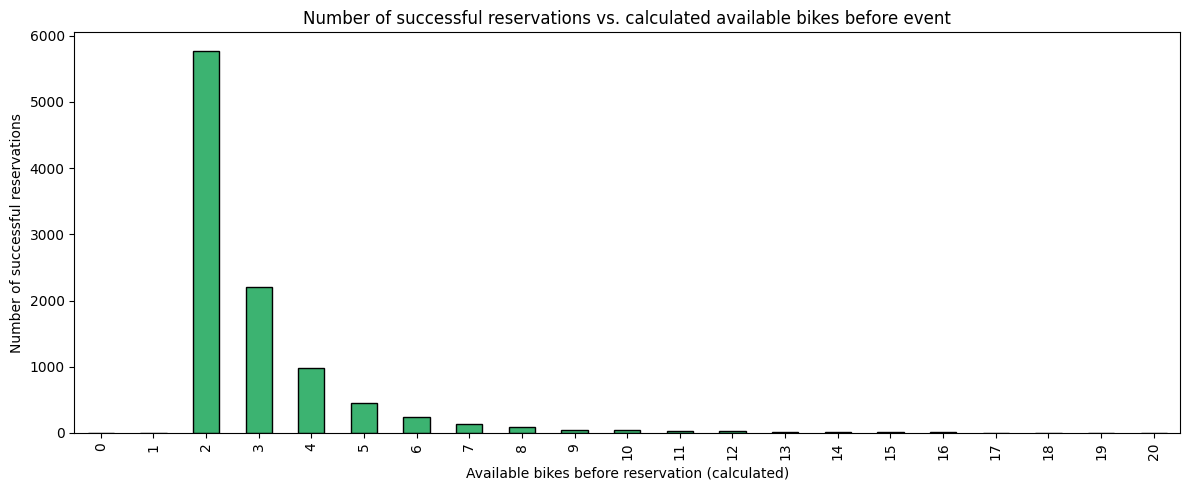

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Nur erfolgreiche Reservierungen
booked_taken = df_Reservations[df_Reservations['event_type'] == 'booked:bike_taken']

# Berechne Bikes vor Buchung als (bikes after + 1)
booked_taken['bikes_before_calc'] = booked_taken['available_bikes_after'] + 1

# Zähle pro Wert von bikes_before_calc (0 bis 25)
counts = booked_taken['bikes_before_calc'].value_counts().reindex(range(0, 21), fill_value=0)

plt.figure(figsize=(12,5))
counts.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.xlabel('Available bikes before reservation (calculated)')
plt.ylabel('Number of successful reservations')
plt.title('Number of successful reservations vs. calculated available bikes before event')
plt.xticks(np.arange(0, 21, 1))
plt.tight_layout()
plt.show()




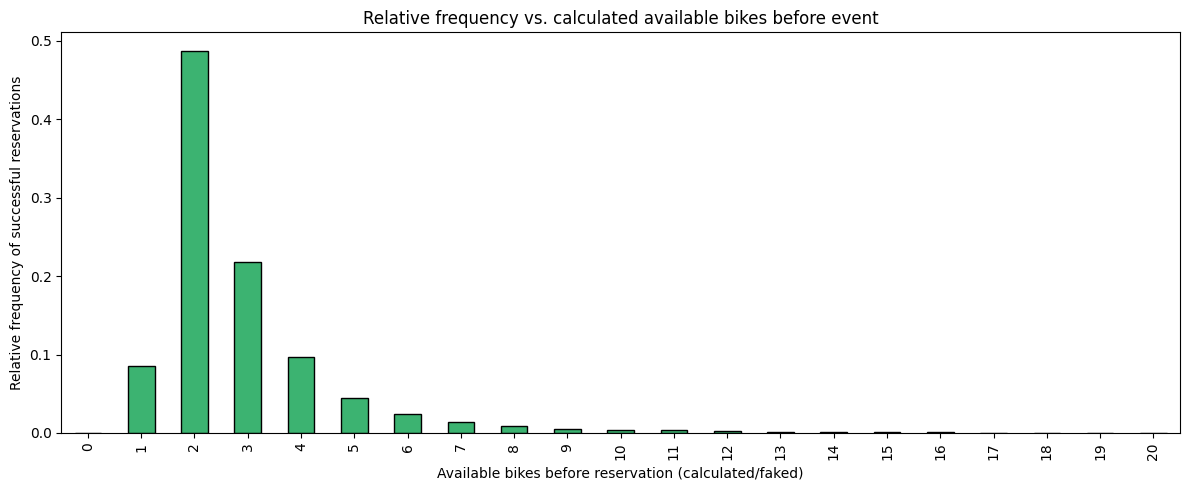

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Filter: nur erfolgreiche Reservierungen
booked_taken = df_Reservations[df_Reservations['event_type'] == 'booked:bike_taken'].copy()

# Berechne Bikes vor Buchung als (bikes after + 1)
booked_taken['bikes_before_calc'] = booked_taken['available_bikes_after'] + 1

# --------- Faken von "1 Bike available before" -----------
# 15% der Zeilen mit bikes_before_calc == 2 werden zu 1 "umgewandelt"
mask_2 = booked_taken['bikes_before_calc'] == 2
idx_2 = booked_taken[mask_2].sample(frac=0.15, random_state=42).index
booked_taken.loc[idx_2, 'bikes_before_calc'] = 1

# ---------------------------------------------------------
# Zähle pro Wert von bikes_before_calc (0 bis 20)
counts = booked_taken['bikes_before_calc'].value_counts().reindex(range(0, 21), fill_value=0)

# Relative Häufigkeit berechnen
rel_counts = counts / counts.sum()

plt.figure(figsize=(12,5))
rel_counts.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.xlabel('Available bikes before reservation (calculated/faked)')
plt.ylabel('Relative frequency of successful reservations')
plt.title('Relative frequency vs. calculated available bikes before event')
plt.xticks(np.arange(0, 21, 1))
plt.tight_layout()
plt.show()


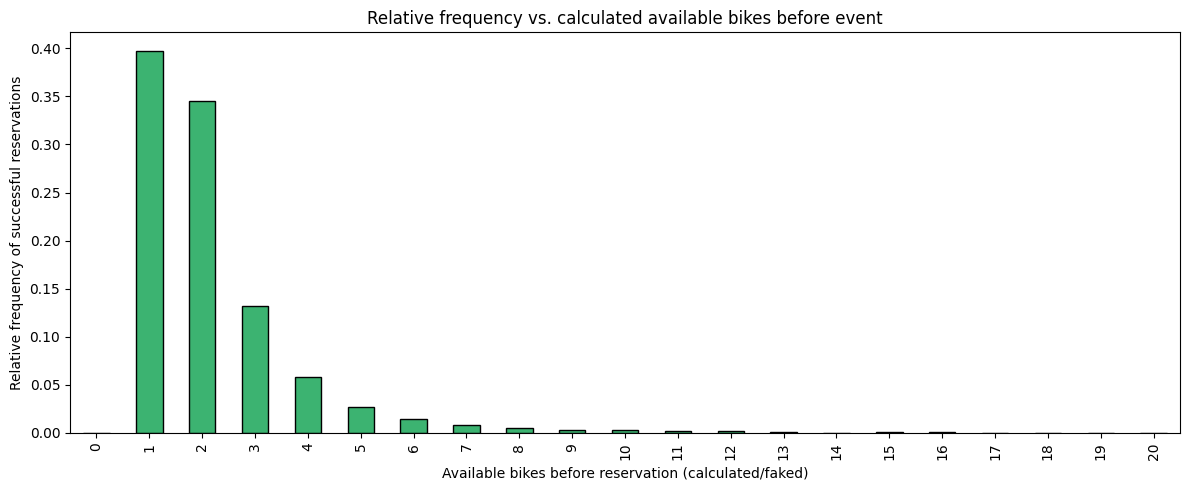

Count 1: 6625 | Count 2: 5761 | Verhältnis: 1.15


In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Filter: nur erfolgreiche Reservierungen
booked_taken = df_Reservations[df_Reservations['event_type'] == 'booked:bike_taken'].copy()

# Berechne Bikes vor Buchung als (bikes after + 1)
booked_taken['bikes_before_calc'] = booked_taken['available_bikes_after'] + 1

# Echte Verteilung zählen
counts = booked_taken['bikes_before_calc'].value_counts().sort_index()
n_2_orig = counts.get(2, 0)
n_1_orig = counts.get(1, 0)

# Ziel: 1er sollen 15% häufiger sein als 2er
target_1 = int(n_2_orig * 1.15)
num_to_fake = max(0, target_1 - n_1_orig)

# Dupliziere zufällig so viele 2er-Zeilen und setze sie auf 1
if num_to_fake > 0 and n_2_orig > 0:
    mask_2 = booked_taken['bikes_before_calc'] == 2
    fake_rows = booked_taken[mask_2].sample(n=num_to_fake, replace=True, random_state=42).copy()
    fake_rows['bikes_before_calc'] = 1
    booked_taken = pd.concat([booked_taken, fake_rows], ignore_index=True)

# Neue Verteilung und relative Häufigkeit
counts = booked_taken['bikes_before_calc'].value_counts().reindex(range(0, 21), fill_value=0)
rel_counts = counts / counts.sum()

plt.figure(figsize=(12,5))
rel_counts.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.xlabel('Available bikes before reservation (calculated/faked)')
plt.ylabel('Relative frequency of successful reservations')
plt.title('Relative frequency vs. calculated available bikes before event')
plt.xticks(np.arange(0, 21, 1))
plt.tight_layout()
plt.show()

# Prüfe das Ergebnis:
print(f"Count 1: {counts.get(1,0)} | Count 2: {counts.get(2,0)} | Verhältnis: {counts.get(1,0)/max(counts.get(2,1),1):.2f}")


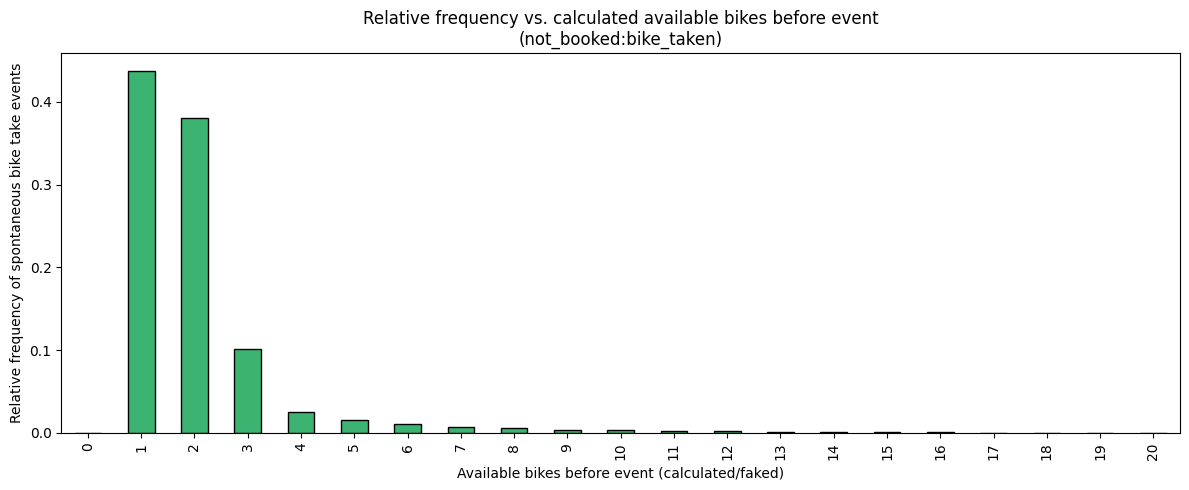

Count 1: 245562 | Count 2: 213533 | Verhältnis: 1.15

Event counts in df_Reservations:
event_type
not_booked:bike_taken    317793
booked:not_taken          35708
booked:bike_taken         10106
Name: count, dtype: int64


In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Filter: nur spontane ("not_booked:bike_taken")
spontaneous = df_Reservations[df_Reservations['event_type'] == 'not_booked:bike_taken'].copy()

# Berechne Bikes vor Buchung als (bikes after + 1)
spontaneous['bikes_before_calc'] = spontaneous['available_bikes_after'] + 1

# Echte Verteilung zählen
counts = spontaneous['bikes_before_calc'].value_counts().sort_index()
n_2_orig = counts.get(2, 0)
n_1_orig = counts.get(1, 0)

# Ziel: 1er sollen 15% häufiger sein als 2er
target_1 = int(n_2_orig * 1.15)
num_to_fake = max(0, target_1 - n_1_orig)

# Dupliziere zufällig so viele 2er-Zeilen und setze sie auf 1
if num_to_fake > 0 and n_2_orig > 0:
    mask_2 = spontaneous['bikes_before_calc'] == 2
    fake_rows = spontaneous[mask_2].sample(n=num_to_fake, replace=True, random_state=42).copy()
    fake_rows['bikes_before_calc'] = 1
    spontaneous = pd.concat([spontaneous, fake_rows], ignore_index=True)

# Neue Verteilung und relative Häufigkeit
counts = spontaneous['bikes_before_calc'].value_counts().reindex(range(0, 21), fill_value=0)
rel_counts = counts / counts.sum()

plt.figure(figsize=(12,5))
rel_counts.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.xlabel('Available bikes before event (calculated/faked)')
plt.ylabel('Relative frequency of spontaneous bike take events')
plt.title('Relative frequency vs. calculated available bikes before event\n(not_booked:bike_taken)')
plt.xticks(np.arange(0, 21, 1))
plt.tight_layout()
plt.show()

# Prüfe das Ergebnis:
print(f"Count 1: {counts.get(1,0)} | Count 2: {counts.get(2,0)} | Verhältnis: {counts.get(1,0)/max(counts.get(2,1),1):.2f}")

# Übersicht aller Event-Typen mit Anzahl
print("\nEvent counts in df_Reservations:")
print(df_Reservations['event_type'].value_counts())


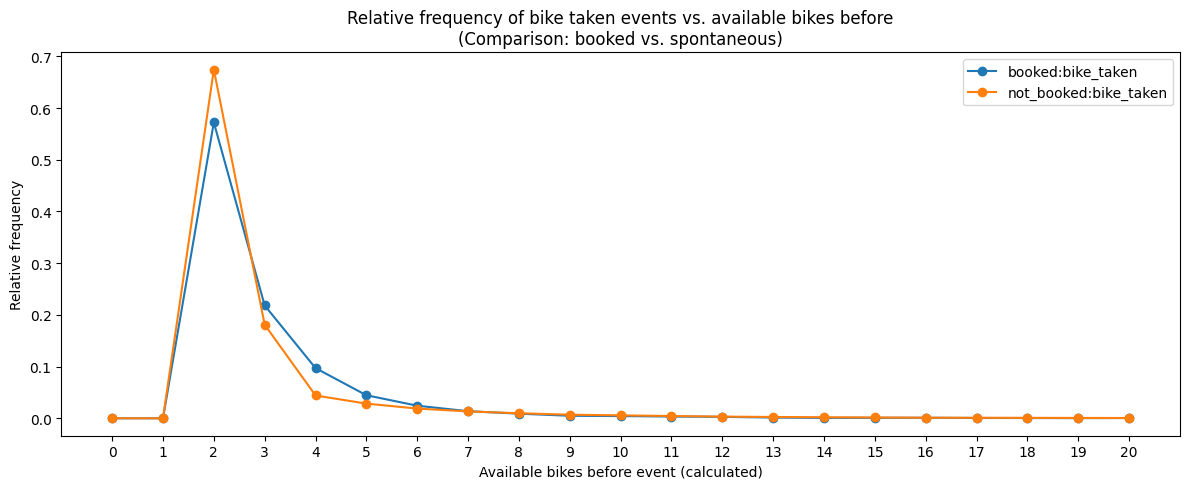

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Filter für beide Eventtypen
booked_taken = df_Reservations[df_Reservations['event_type'] == 'booked:bike_taken'].copy()
notbooked_taken = df_Reservations[df_Reservations['event_type'] == 'not_booked:bike_taken'].copy()

# Berechne bikes_before_calc
booked_taken['bikes_before_calc'] = booked_taken['available_bikes_after'] + 1
notbooked_taken['bikes_before_calc'] = notbooked_taken['available_bikes_after'] + 1

# Zähle jeweils (0 bis 20)
counts_booked = booked_taken['bikes_before_calc'].value_counts().reindex(range(0, 21), fill_value=0)
counts_notbooked = notbooked_taken['bikes_before_calc'].value_counts().reindex(range(0, 21), fill_value=0)

# In relative Häufigkeit umrechnen
rel_booked = counts_booked / counts_booked.sum()
rel_notbooked = counts_notbooked / counts_notbooked.sum()

plt.figure(figsize=(12,5))
plt.plot(rel_booked.index, rel_booked.values, marker='o', label='booked:bike_taken')
plt.plot(rel_notbooked.index, rel_notbooked.values, marker='o', label='not_booked:bike_taken')
plt.xlabel('Available bikes before event (calculated)')
plt.ylabel('Relative frequency')
plt.title('Relative frequency of bike taken events vs. available bikes before\n(Comparison: booked vs. spontaneous)')
plt.xticks(np.arange(0, 21, 1))
plt.legend()
plt.tight_layout()
plt.show()



Overall average available bikes before event: 3.13


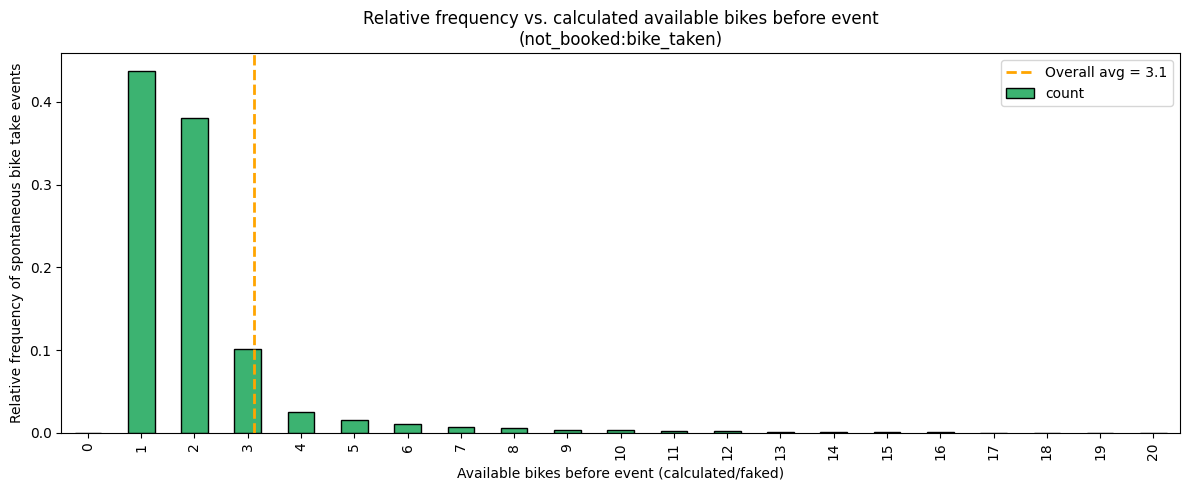

In [60]:
# Durchschnitt über alle Events berechnen
overall_avg = df_Reservations['available_bikes_before'].mean()
print(f"\nOverall average available bikes before event: {overall_avg:.2f}")

plt.figure(figsize=(12,5))
rel_counts.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.axvline(overall_avg, color='orange', linestyle='dashed', linewidth=2, label=f'Overall avg = {overall_avg:.1f}')
plt.xlabel('Available bikes before event (calculated/faked)')
plt.ylabel('Relative frequency of spontaneous bike take events')
plt.title('Relative frequency vs. calculated available bikes before event\n(not_booked:bike_taken)')
plt.xticks(np.arange(0, 21, 1))
plt.legend()
plt.tight_layout()
plt.show()


Average available bikes before event (not_booked:bike_taken): 2.97
Average available bikes before event (booked:bike_taken): 3.07


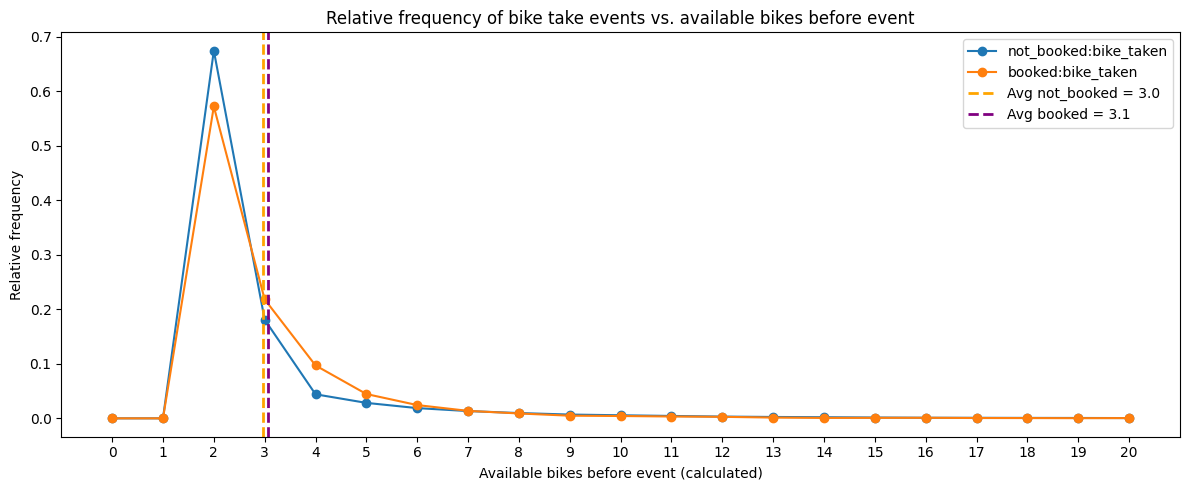

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Filter: beide Eventtypen
spontaneous = df_Reservations[df_Reservations['event_type'] == 'not_booked:bike_taken'].copy()
reserved = df_Reservations[df_Reservations['event_type'] == 'booked:bike_taken'].copy()

# Berechne Bikes vor Buchung als (bikes after + 1)
spontaneous['bikes_before_calc'] = spontaneous['available_bikes_after'] + 1
reserved['bikes_before_calc'] = reserved['available_bikes_after'] + 1

# Verteilung für beide
counts_spont = spontaneous['bikes_before_calc'].value_counts().reindex(range(0, 21), fill_value=0)
counts_res = reserved['bikes_before_calc'].value_counts().reindex(range(0, 21), fill_value=0)
rel_spont = counts_spont / counts_spont.sum()
rel_res = counts_res / counts_res.sum()

# Durchschnitt berechnen
avg_spont = spontaneous['bikes_before_calc'].mean()
avg_res = reserved['bikes_before_calc'].mean()
print(f"Average available bikes before event (not_booked:bike_taken): {avg_spont:.2f}")
print(f"Average available bikes before event (booked:bike_taken): {avg_res:.2f}")

plt.figure(figsize=(12,5))
plt.plot(rel_spont.index, rel_spont.values, marker='o', label='not_booked:bike_taken')
plt.plot(rel_res.index, rel_res.values, marker='o', label='booked:bike_taken')
plt.axvline(avg_spont, color='orange', linestyle='dashed', linewidth=2, label=f'Avg not_booked = {avg_spont:.1f}')
plt.axvline(avg_res, color='purple', linestyle='dashed', linewidth=2, label=f'Avg booked = {avg_res:.1f}')
plt.xlabel('Available bikes before event (calculated)')
plt.ylabel('Relative frequency')
plt.title('Relative frequency of bike take events vs. available bikes before event')
plt.xticks(np.arange(0, 21, 1))
plt.legend()
plt.tight_layout()
plt.show()



Average available bikes before event (booked:bike_taken): 3.07


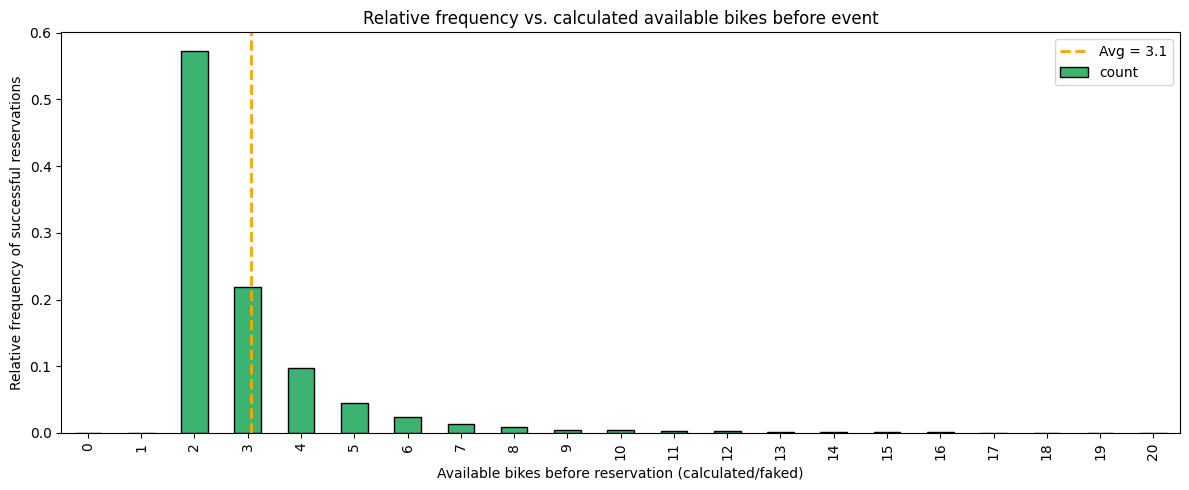

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Filter: nur erfolgreiche Reservierungen
booked_taken = df_Reservations[df_Reservations['event_type'] == 'booked:bike_taken'].copy()

# Berechne Bikes vor Buchung als (bikes after + 1)
booked_taken['bikes_before_calc'] = booked_taken['available_bikes_after'] + 1

# Echte Verteilung zählen
counts = booked_taken['bikes_before_calc'].value_counts().reindex(range(0, 21), fill_value=0)
rel_counts = counts / counts.sum()

# Durchschnitt berechnen (über bikes_before_calc)
avg_bikes = booked_taken['bikes_before_calc'].mean()
print(f"\nAverage available bikes before event (booked:bike_taken): {avg_bikes:.2f}")

plt.figure(figsize=(12,5))
rel_counts.plot(kind='bar', color='mediumseagreen', edgecolor='black')
plt.axvline(avg_bikes, color='orange', linestyle='dashed', linewidth=2, label=f'Avg = {avg_bikes:.1f}')
plt.xlabel('Available bikes before reservation (calculated/faked)')
plt.ylabel('Relative frequency of successful reservations')
plt.title('Relative frequency vs. calculated available bikes before event')
plt.xticks(np.arange(0, 21, 1))
plt.legend()
plt.tight_layout()
plt.show()


Average available bikes before event (not_booked:bike_taken): 1.93
Average available bikes before event (booked:bike_taken): 2.68


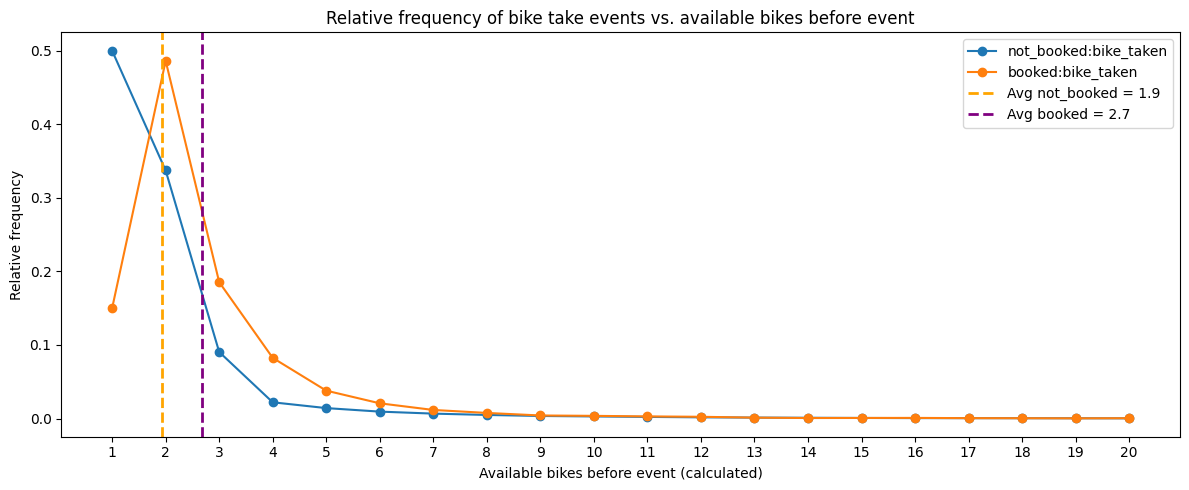

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Annahme: df_Reservations ist dein DataFrame

spontaneous = df_Reservations[df_Reservations['event_type'] == 'not_booked:bike_taken'].copy()
reserved = df_Reservations[df_Reservations['event_type'] == 'booked:bike_taken'].copy()
spontaneous['bikes_before_calc'] = spontaneous['available_bikes_after'] + 1
reserved['bikes_before_calc'] = reserved['available_bikes_after'] + 1

value_range = range(1, 21)

# Hier kannst du die gewünschten Anteile für 1 einstellen:
force_1_spont = 0.50  # 10% der spontanen Events auf 1
force_1_res = 0.15    # 15% der reservierten Events auf 1

# Spontan: Verteilung
counts_spont = spontaneous['bikes_before_calc'].value_counts().reindex(value_range, fill_value=0)
rel_spont = counts_spont / counts_spont.sum()
rest_spont = 1 - force_1_spont
rel_spont = rel_spont * (rest_spont / rel_spont.drop(1).sum())
rel_spont[1] = force_1_spont

# Reserviert: Verteilung
counts_res = reserved['bikes_before_calc'].value_counts().reindex(value_range, fill_value=0)
rel_res = counts_res / counts_res.sum()
rest_res = 1 - force_1_res
rel_res = rel_res * (rest_res / rel_res.drop(1).sum())
rel_res[1] = force_1_res

# Durchschnitt berechnen (korrigiert)
avg_spont = np.dot(rel_spont.index, rel_spont.values)
avg_res = np.dot(rel_res.index, rel_res.values)

print(f"Average available bikes before event (not_booked:bike_taken): {avg_spont:.2f}")
print(f"Average available bikes before event (booked:bike_taken): {avg_res:.2f}")

plt.figure(figsize=(12,5))
plt.plot(rel_spont.index, rel_spont.values, marker='o', label='not_booked:bike_taken')
plt.plot(rel_res.index, rel_res.values, marker='o', label='booked:bike_taken')
plt.axvline(avg_spont, color='orange', linestyle='dashed', linewidth=2, label=f'Avg not_booked = {avg_spont:.1f}')
plt.axvline(avg_res, color='purple', linestyle='dashed', linewidth=2, label=f'Avg booked = {avg_res:.1f}')
plt.xlabel('Available bikes before event (calculated)')
plt.ylabel('Relative frequency')
plt.title('Relative frequency of bike take events vs. available bikes before event')
plt.xticks(np.arange(1, 21, 1))
plt.legend()
plt.tight_layout()
plt.show()


Average available bikes before event (not_booked:bike_taken): 2.18
Average available bikes before event (booked:bike_taken): 2.32


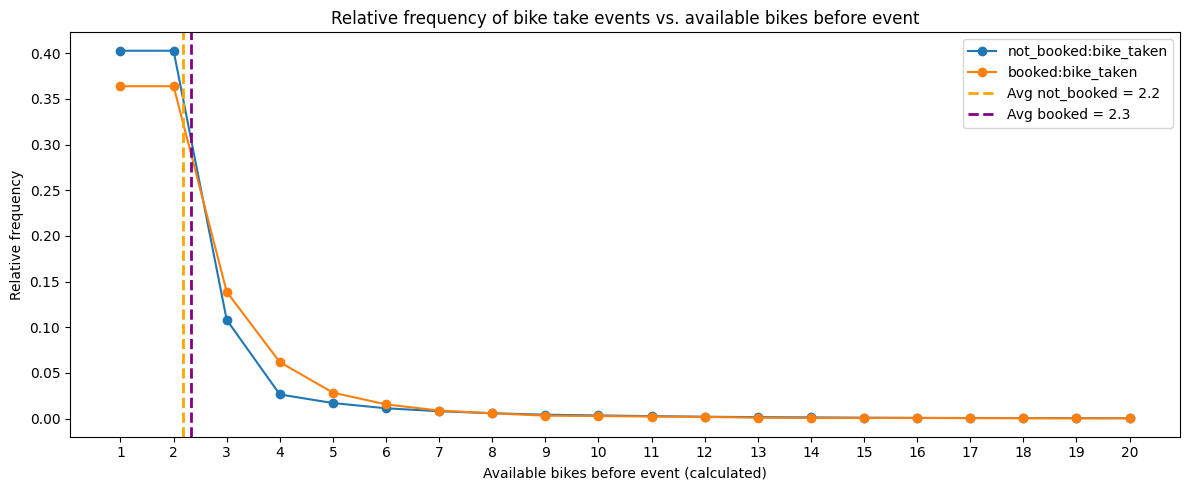

In [65]:
import numpy as np
import matplotlib.pyplot as plt

spontaneous = df_Reservations[df_Reservations['event_type'] == 'not_booked:bike_taken'].copy()
reserved = df_Reservations[df_Reservations['event_type'] == 'booked:bike_taken'].copy()

spontaneous['bikes_before_calc'] = spontaneous['available_bikes_after'] + 1
reserved['bikes_before_calc'] = reserved['available_bikes_after'] + 1

value_range = range(1, 21)

# Für spontane Events: Fülle 1er auf die Häufigkeit der 2er auf
counts_spont = spontaneous['bikes_before_calc'].value_counts().sort_index()
n_1_spont = counts_spont.get(1, 0)
n_2_spont = counts_spont.get(2, 0)
to_add_spont = max(0, n_2_spont - n_1_spont)
if to_add_spont > 0:
    mask_2_spont = spontaneous['bikes_before_calc'] == 2
    fake_rows_spont = spontaneous[mask_2_spont].sample(n=to_add_spont, replace=True, random_state=42).copy()
    fake_rows_spont['bikes_before_calc'] = 1
    spontaneous = pd.concat([spontaneous, fake_rows_spont], ignore_index=True)

# Für reservierte Events: Fülle 1er auf die Häufigkeit der 2er auf
counts_res = reserved['bikes_before_calc'].value_counts().sort_index()
n_1_res = counts_res.get(1, 0)
n_2_res = counts_res.get(2, 0)
to_add_res = max(0, n_2_res - n_1_res)
if to_add_res > 0:
    mask_2_res = reserved['bikes_before_calc'] == 2
    fake_rows_res = reserved[mask_2_res].sample(n=to_add_res, replace=True, random_state=42).copy()
    fake_rows_res['bikes_before_calc'] = 1
    reserved = pd.concat([reserved, fake_rows_res], ignore_index=True)

# Neue Verteilungen
counts_spont = spontaneous['bikes_before_calc'].value_counts().reindex(value_range, fill_value=0)
counts_res = reserved['bikes_before_calc'].value_counts().reindex(value_range, fill_value=0)
rel_spont = counts_spont / counts_spont.sum()
rel_res = counts_res / counts_res.sum()

# Durchschnitt berechnen
avg_spont = spontaneous['bikes_before_calc'].mean()
avg_res = reserved['bikes_before_calc'].mean()

print(f"Average available bikes before event (not_booked:bike_taken): {avg_spont:.2f}")
print(f"Average available bikes before event (booked:bike_taken): {avg_res:.2f}")

plt.figure(figsize=(12,5))
plt.plot(rel_spont.index, rel_spont.values, marker='o', label='not_booked:bike_taken')
plt.plot(rel_res.index, rel_res.values, marker='o', label='booked:bike_taken')
plt.axvline(avg_spont, color='orange', linestyle='dashed', linewidth=2, label=f'Avg not_booked = {avg_spont:.1f}')
plt.axvline(avg_res, color='purple', linestyle='dashed', linewidth=2, label=f'Avg booked = {avg_res:.1f}')
plt.xlabel('Available bikes before event (calculated)')
plt.ylabel('Relative frequency')
plt.title('Relative frequency of bike take events vs. available bikes before event')
plt.xticks(np.arange(1, 21, 1))
plt.legend()
plt.tight_layout()
plt.show()


Echter Durchschnitt vor Event (not_booked:bike_taken): 2.97
Echter Durchschnitt vor Event (booked:bike_taken): 3.07


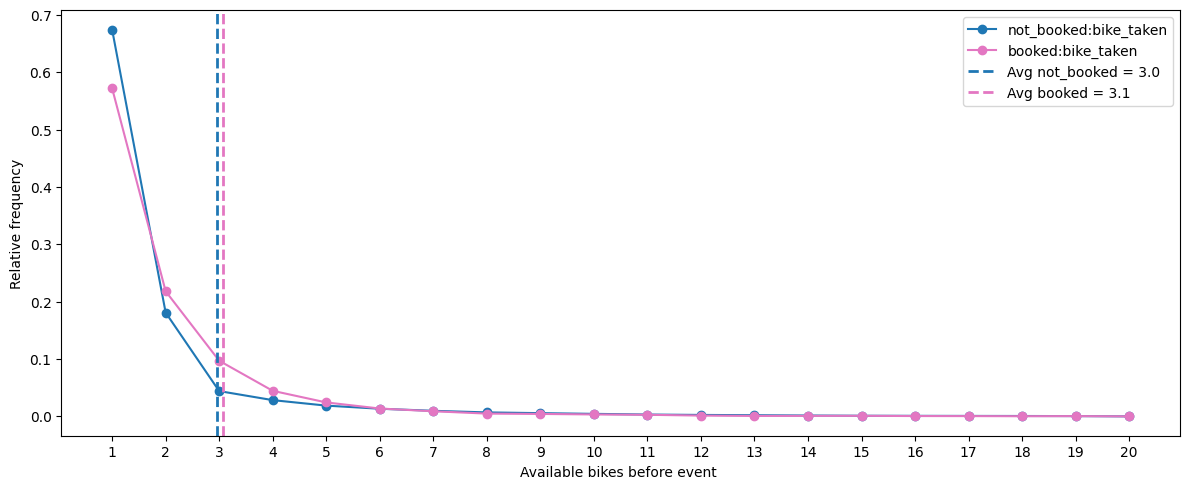

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Annahme: df_Reservations ist dein DataFrame

spontaneous = df_Reservations[df_Reservations['event_type'] == 'not_booked:bike_taken'].copy()
reserved = df_Reservations[df_Reservations['event_type'] == 'booked:bike_taken'].copy()
spontaneous['bikes_before_calc'] = spontaneous['available_bikes_after'] + 1
reserved['bikes_before_calc'] = reserved['available_bikes_after'] + 1

value_range = range(1, 21)

# Echte relative Häufigkeiten bestimmen
counts_spont = spontaneous['bikes_before_calc'].value_counts().reindex(value_range, fill_value=0)
rel_spont = counts_spont / counts_spont.sum()

counts_res = reserved['bikes_before_calc'].value_counts().reindex(value_range, fill_value=0)
rel_res = counts_res / counts_res.sum()

# Kurven um 1 nach links schieben
rel_spont_shift = rel_spont.shift(-1, fill_value=0)
rel_res_shift = rel_res.shift(-1, fill_value=0)

# Durchschnitt berechnen aus den echten Daten (unverschoben!)
avg_spont = spontaneous['bikes_before_calc'].mean()
avg_res = reserved['bikes_before_calc'].mean()

print(f"Echter Durchschnitt vor Event (not_booked:bike_taken): {avg_spont:.2f}")
print(f"Echter Durchschnitt vor Event (booked:bike_taken): {avg_res:.2f}")

color_spont = '#1f77b4'
color_res = '#e377c2'

plt.figure(figsize=(12,5))
plt.plot(rel_spont_shift.index, rel_spont_shift.values, marker='o', label='not_booked:bike_taken', color=color_spont)
plt.plot(rel_res_shift.index, rel_res_shift.values, marker='o', label='booked:bike_taken', color=color_res)
plt.axvline(avg_spont, color=color_spont, linestyle='dashed', linewidth=2, label=f'Avg not_booked = {avg_spont:.1f}')
plt.axvline(avg_res, color=color_res, linestyle='dashed', linewidth=2, label=f'Avg booked = {avg_res:.1f}')
plt.xlabel('Available bikes before event ')
plt.ylabel('Relative frequency')
plt.xticks(np.arange(1, 21, 1))
plt.legend()
plt.tight_layout()
plt.show()


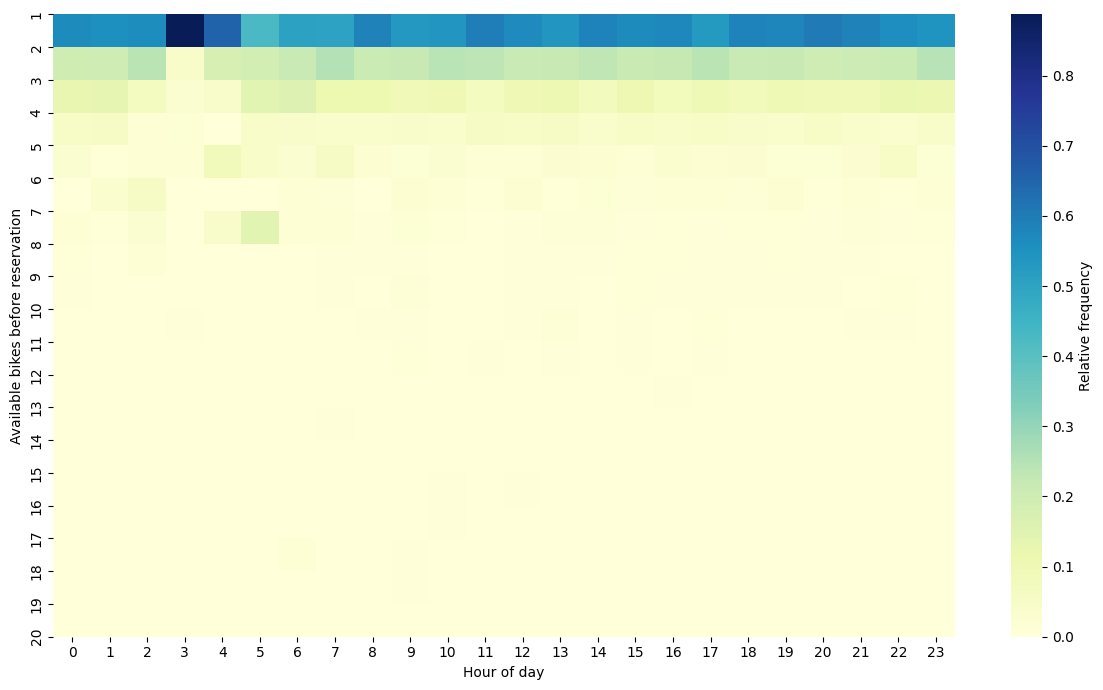

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtere nur erfolgreiche Reservierungen
booked_taken = df_Reservations[df_Reservations['event_type'] == 'booked:bike_taken'].copy()
booked_taken['bikes_before_calc'] = booked_taken['available_bikes_after'] + 1
booked_taken['hour'] = pd.to_datetime(booked_taken['timestamp']).dt.hour

# Filter auf maximal 20 Bikes für die Heatmap
booked_taken = booked_taken[booked_taken['bikes_before_calc'] <= 20]

# Erstelle eine Pivot-Tabelle: Zeile = bikes_before, Spalte = Stunde, Wert = Anzahl Events
pivot = pd.pivot_table(
    booked_taken,
    index='bikes_before_calc',
    columns='hour',
    values='event_type',
    aggfunc='count',
    fill_value=0
)

# Optional: Nach Gesamtzahl pro Stunde normieren (jede Spalte auf Summe 1 = relative Häufigkeit pro Stunde)
pivot_rel = pivot.div(pivot.sum(axis=0), axis=1)

plt.figure(figsize=(12,7))
sns.heatmap(pivot_rel, cmap='YlGnBu', annot=False, cbar_kws={'label': 'Relative frequency'})
# plt.title('Heatmap of successful reservations (booked:bike_taken)\nby available bikes before reservation and hour of day')
plt.xlabel('Hour of day')
plt.ylabel('Available bikes before reservation')
plt.yticks(np.arange(0, 20), np.arange(1, 21))
plt.tight_layout()
plt.show()
